In [0]:
import pandas as pd
import numpy as np
import logging
import warnings
import keras

# Squash warning messages
# warnings.showwarning = lambda *args, **kwargs: None

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from keras.preprocessing.sequence import TimeseriesGenerator

# Import the necessary functions for reading iww sql db
from pyspark.sql.functions import *

# Use arrow conversion for spark DF to pandas DF and vice versa
spark.conf.set("spark.sql.execution.arrow.enabled", "true")

#It seems Azure databricks required Pandas version <= 0.23
print("Pandas ", pd.__version__)
print("Numpy ", np.__version__)

Pandas 0.23.0
Numpy 1.14.3

In [0]:

#Reading new IWW Water Quality data table
PI_SDF = spark.read.format("jdbc") \
	.option("driver", "com.microsoft.sqlserver.jdbc.SQLServerDriver")\
	.option("url", "jdbc:sqlserver://sqlqutarmsvruw2003.database.windows.net;databaseName=edsqutarmsqluw2005") \
	.option("dbtable", "PI_TAGVALUES")\
	.option("user", "ABO_IWWD_Admin") \
	.option("password","!WWD_ad_2019").load()

#Using Pandas dataframes with arrow conversion
PI_Data = PI_SDF.select("*").toPandas()

/databricks/python/lib/python3.6/site-packages/pyarrow/__init__.py:159: UserWarning: pyarrow.open_stream is deprecated, please use pyarrow.ipc.open_stream
 warnings.warn("pyarrow.open_stream is deprecated, please use "

In [0]:
#Pivot the SQL table so that each tag is its own column

PI_Data = PI_Data.pivot(index='TagTime', columns='TagName', values='TagValue')
PI_Data.reset_index(inplace=True)


In [0]:
#These are the specific tags that are the most strongly correlated to toxicity specified by the business

forecast_column1 = PI_Data['WW_PONDA_OUT_TSS']
# forecast_column2 = PI_Data['WW_PONDA_OUT_COD']
# forecast_column3 = PI_Data['WW_PONDA_OUT_PH']
# forecast_column4 = PI_Data['WW_PONDA_OUT_OG']
# forecast_column5 = PI_Data['PONDE_OUT_TSS']
# forecast_column6 = PI_Data['PONDE_OUT_COD']
# forecast_column7 = PI_Data['PONDE_OUT_PH']
# forecast_column8 = PI_Data['WW_PONDE_OUT_OG']

#storing individual dates for later usage
dates_column = PI_Data['TagTime']



data1 = pd.DataFrame(dates_column, forecast_column1)
# data2 = pd.DataFrame(dates_column, forecast_column2)
# data3 = pd.DataFrame(dates_column, forecast_column3)
# data4 = pd.DataFrame(dates_column, forecast_column4)
# data5 = pd.DataFrame(dates_column, forecast_column5)
# data6 = pd.DataFrame(dates_column, forecast_column6)
# data7 = pd.DataFrame(dates_column, forecast_column7)
# data8 = pd.DataFrame(dates_column, forecast_column8)




Out[33]: 1752

In [0]:
from pyspark.sql.types import FloatType
data = spark.createDataFrame(forecast_column1, FloatType())


In [0]:

from pyspark.sql.functions import round

data = data.dropna() 

# Round up the data to one decimal point. This saves compute effort
columns = data.columns
for i in columns:
  data = data.withColumn(i, round(i, 1))


['value']

In [0]:


values = data.collect() # should return a list 

# This estimator standardizes features by removing the mean and scaling to unit variance such that the values are centered around 0 
# This allows all variables / columns to carry the same weight
scaler = StandardScaler()
scaled = scaler.fit_transform(values)



# Create features and label dataset. NOTE: We're predicting a value 30 daysinto the future. 

X = scaled[:][:-30] # All of the above columns and remove readings from last 30 days
y = scaled[:][30:] # target/label column and remove readings from first 30 days
X_removed = scaled[:][-30:]
y_removed = scaled[:][:30]
# print(scaled.shape)
# print(X.shape)
# print(y.shape)
# print(y_removed.shape)
# print(X_removed.shape)
# X = values[:][:-144] # All of the above columns and remove readings from last 30 days
# y = values[:, 57][144:] #target/label column and remove readings from first 30 days


(1752, 1)
(1722, 1)
(1722, 1)
(30, 1)
(30, 1)

In [0]:
from sklearn.model_selection import train_test_split

# split into train and test sets using standard SKlearn tool
trainX, testX, trainY, testY = train_test_split(X, y, test_size=0.20, random_state=42)

# Create overlapping windows of lagged values for training and testing datasets
# Crossing over 3 months of daily data
timesteps = 90
train_generator = TimeseriesGenerator(trainX, trainY, length=timesteps, sampling_rate=1, batch_size=timesteps)
test_generator = TimeseriesGenerator(testX, testY, length=timesteps, sampling_rate=1, batch_size=timesteps)

In [0]:
train_X, train_y = train_generator[0]
test_X, test_y = test_generator[0]

train_samples = train_X.shape[0]*len(train_generator)
test_samples = test_X.shape[0]*len(test_generator)

print("Total Records (n): {}".format(data.count()))
print("Total Records after adjusting for 30 days: {}".format(len(X)))
print("Number of samples in training set (.8 * n): trainX = {}".format(trainX.shape[0]))
print("Number of samples in testing set (.2 * n): testX = {}".format(testX.shape[0]))
print("Size of individual batches: {}".format(test_X.shape[1]))
print("Number of total samples in training feature set: {}".format(train_samples))
print("Number of samples in testing feature set: {}".format(test_samples))

Total Records (n): 1752
Total Records after adjusting for 30 days: 1722
Number of samples in training set (.8 * n): trainX = 1377
Number of samples in testing set (.2 * n): testX = 345
Size of individual batches: 90
Number of total samples in training feature set: 1350
Number of samples in testing feature set: 270

In [0]:

#Create a tensorboard for experiment visualization

from time import time
from keras.callbacks import TensorBoard
tb_dir = '/tmp/tensorflow_log_dir/{}'.format(time())
tensorboard = TensorBoard(log_dir = tb_dir)
dbutils.tensorboard.start(tb_dir)

TensorBoard log directory set to: /tmp/tensorflow_log_dir/1606255343.5672064. 
 View TensorBoard

In [0]:

from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM
from keras.layers.advanced_activations import LeakyReLU
from keras.callbacks import EarlyStopping
import mlflow
import mlflow.keras

# LSTM expects the input data in a specific 3D format of test sample size, time steps, no. of input features. We had defined the time steps as n_lag variable in previous step.  Time steps are the past observations that the network will learn from (e.g. backpropagation through time).

# For details on what individual hyperparameters mean, see here: https://github.com/keras-team/keras/blob/master/keras/layers/recurrent.py#L2051

units = 128
num_epoch = 5000
learning_rate = 0.00144

#store data to specific mlFlow experiment in databricks workspace
with mlflow.start_run(experiment_id=4376005557947993, nested=True):
  #create a sequnetial keras neural net
  model = Sequential()
  #This is the core layer... a GPU enabled deep neural network
  model.add(LSTM(units, input_shape=(train_X.shape[1], train_X.shape[2])))
  #Rectifier
  model.add(LeakyReLU(alpha=0.5)) 
  #add standard dropout and dense layers
  model.add(Dropout(0.1))
  model.add(Dense(1))

  
  # Use ADAM gradient descent optimizer. More info: https://arxiv.org/abs/1412.6980
  adam = Adam(lr=learning_rate)
  
  # Stop training when a monitored quantity has stopped improving.
  callback = [EarlyStopping(monitor="loss", min_delta = 0.00001, patience = 50, mode = 'auto', restore_best_weights=True), tensorboard] 

  # Using regression loss function 'Mean Standard Error' and validation metric 'Mean Absolute Error'
  model.compile(loss='mse', optimizer=adam, metrics=['mae'])
  
# train model to data
  history = model.fit_generator(train_generator, \
                                epochs=num_epoch, \
                                validation_data=test_generator, \
                                callbacks = callback, \
                                verbose=2, \
                                shuffle=False, \
                                initial_epoch=0)


  mlflow.log_param("Units", units)
  mlflow.log_param("Epochs", num_epoch)
  mlflow.log_param("Learning Rate", learning_rate)
  mlflow.log_param("Lags cosidered", timesteps)

#   Return loss value and metric value
  score = model.evaluate_generator(test_generator, verbose=0)   
  mlflow.log_metric("Test Loss", score[0]) 
  mlflow.log_metric("MAE", score[1])   
  mlflow.log_metric("Actual Epochs", len(history.history['loss']))
  mlflow.keras.log_model(model, "LSTM Model")



--------------------------------------------------------------------------- 
 NameError Traceback (most recent call last)
 <command-32708325344183> in <module> 
 21 model = Sequential ( ) 
 22 #This is the core layer... a GPU enabled deep neural network 
 ---> 23 model . add ( LSTM ( units , input_shape = ( train_X . shape [ 1 ] , train_X . shape [ 2 ] ) ) ) 
 24 #Rectifier 
 25 model . add ( LeakyReLU ( alpha = 0.5 ) ) 

 NameError : name 'train_X' is not defined

In [0]:

#calculate model predictions for both train dates and test dates (and overlap)
yhat_train_temp = model.predict_generator(train_generator)
yhat_test_temp = model.predict_generator(test_generator)

#To be used for later toxicity forecastin
# x_forecast = np.arange(30)
# x_forecast = x_forecast + scaled.shape[0]

# forecast = model.predict(x_forecast)

n_lead = 1
yhat_train = yhat_train_temp[:, n_lead-1]
yhat_test = yhat_test_temp[:, n_lead-1] 

# training results
yhat_train_plot = np.empty(shape=[y.shape[0],])
yhat_train_plot[:] = np.nan
yhat_train.shape = yhat_train.shape[0]
yhat_train_plot.shape = yhat_train_plot.shape[0]
yhat_train_plot[timesteps:len(yhat_train)+timesteps] = yhat_train
  
#test results
yhat_test_plot = np.empty(shape=[y.shape[0],])
yhat_test_plot[:] = np.nan
yhat_test.shape = yhat_test.shape[0]
yhat_test_plot.shape = yhat_test_plot.shape[0]
yhat_test_plot[len(yhat_train)+(timesteps*2):len(y)] = yhat_test

#used for debugging data set sizes
# print(scaled.shape)
# print(y.shape)
# print(yhat_test.shape)
# print(yhat_train.shape)
# print(X.shape)
# print(y.shape)
# print(y_removed.shape)
# print(X_removed.shape)

90
1
(1752, 1)
(1722, 1)
(255,)
(1287,)
(1722, 1)
(1722, 1)
(30, 1)
(30, 1)

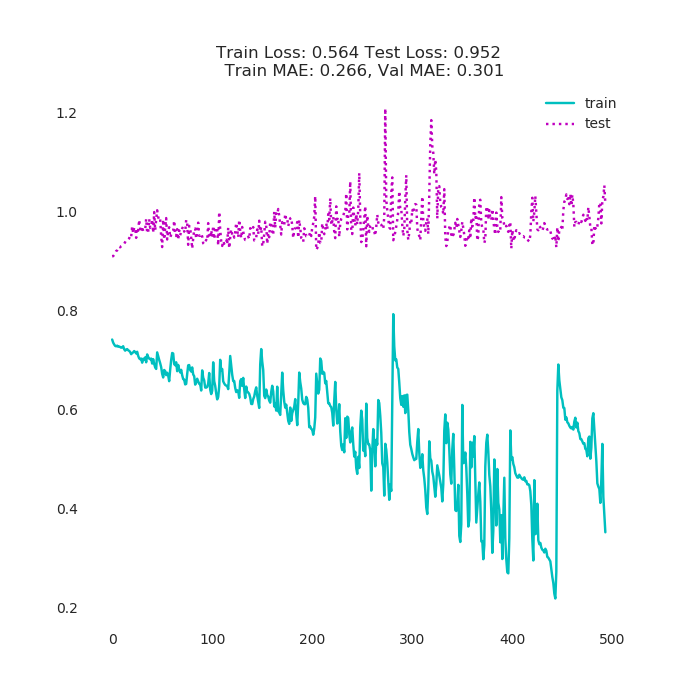

In [0]:
from matplotlib import pyplot


# Calculate the train loss and train metric, in this case mean absolute error
train_loss = np.mean(history.history['loss'])
train_mae = np.mean(history.history['mean_absolute_error'])

title = 'Train Loss: {0:.3f} Test Loss: {1:.3f}\n  Train MAE: {2:.3f}, Val MAE: {3:.3f}'.format(train_loss, score[0], train_mae, score[1])

# Plot loss function
fig = pyplot.figure()
pyplot.style.use('seaborn')

pyplot.plot(history.history['loss'], 'c-', label='train')
pyplot.plot(history.history['val_loss'], 'm:', label='test')
# pyplot.text(epoch-2, 0.07, rmse , style='italic')
pyplot.title(title)
pyplot.legend()
pyplot.grid(True)
fig.set_size_inches(w=7,h=7)
pyplot.close()
display(fig)

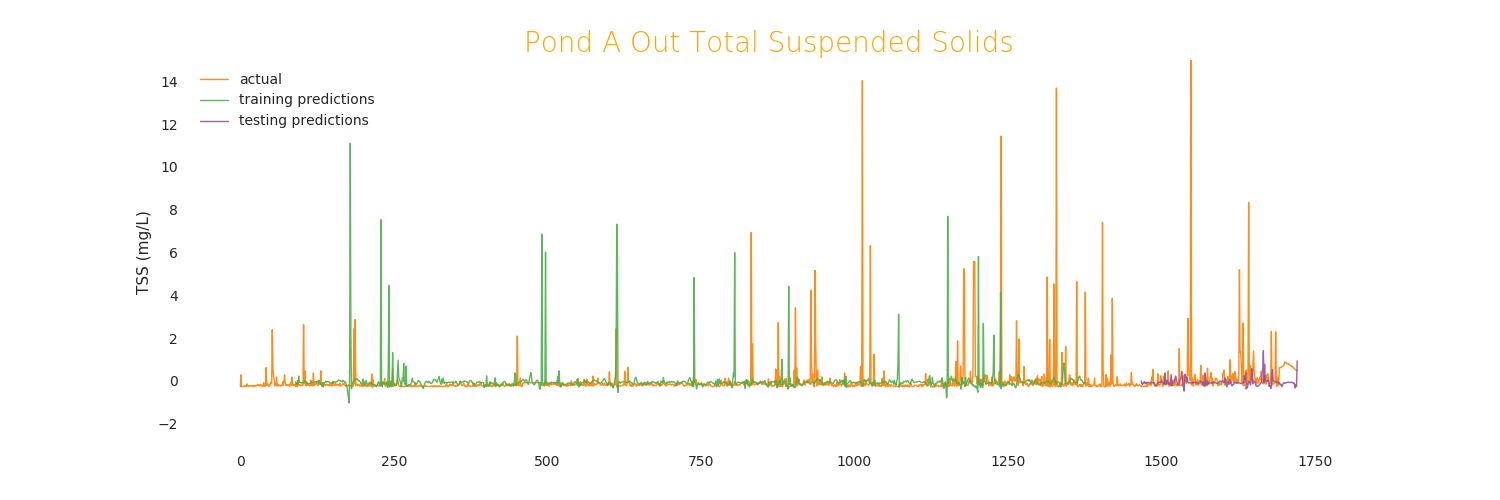

In [0]:
#Plot results

fig = pyplot.figure()
pyplot.style.use('seaborn')
palette = pyplot.get_cmap('Set1')

pyplot.plot(y, marker='', color=palette(4), linewidth=1, alpha=0.9, label='actual')
pyplot.plot(yhat_train_plot, marker='', color=palette(2), linewidth=1, alpha=0.9, label='training predictions')
pyplot.plot(yhat_test_plot, marker='', color=palette(3), linewidth=1, alpha=0.9, label='testing predictions')


pyplot.title('Pond A Out Total Suspended Solids', loc='center', fontsize=20, fontweight=5, color='orange')
pyplot.ylabel('TSS (mg/L)')
axes = pyplot.gca()
axes.set_ylim([-3,15])
pyplot.legend()
fig.set_size_inches(w=15,h=5)
pyplot.close()

display(fig)

(90, 1)

In [0]:
#This will be used later for forecasting actual toxicity readings when correlation / data is available
# model.reset_states()

# predictions = model.predict(train_X)

# print(predictions.shape)

# forecasts1 = []
# currentStep = predictions[:,-1:]

# for i in range(30):
#   currentStep = model.predict([currentStep,1])
#   forecasts1.append(currentStep)



--------------------------------------------------------------------------- 
 AttributeError Traceback (most recent call last)
 <command-4376005557948000> in <module> () 
 4 
 5 for i in range ( 30 ) : 
 ----> 6 currentStep = model . predict ( [ currentStep , 1 ] ) 
 7 forecasts1 . append ( currentStep ) 
 8 

 /databricks/python/lib/python3.6/site-packages/keras/engine/training.py in predict (self, x, batch_size, verbose, steps) 
 1147 'argument.')
 1148 # Validate user data. 
 -> 1149 x , _ , _ = self . _standardize_user_data ( x ) 
 1150 if self . stateful : 
 1151 if x [ 0 ] . shape [ 0 ] > batch_size and x [ 0 ] . shape [ 0 ] % batch_size != 0 : 

 /databricks/python/lib/python3.6/site-packages/keras/engine/training.py in _standardize_user_data (self, x, y, sample_weight, class_weight, check_array_lengths, batch_size) 
 749 feed_input_shapes , 
 750 check_batch_axis = False , # Don't enforce the batch size. 
 --> 751 exception_prefix='input')
 752 
 753 if y is not None : 

 /databricks/python/lib/python3.6/site-packages/keras/engine/training_utils.py in standardize_input_data (data, names, shapes, check_batch_axis, exception_prefix) 
 90 data = data . values if data . __class__ . __name__ == 'DataFrame' else data
 91 data = [ data ] 
 ---> 92 data = [ standardize_single_array ( x ) for x in data ] 
 93 
 94 if len ( data ) != len ( names ) : 

 /databricks/python/lib/python3.6/site-packages/keras/engine/training_utils.py in <listcomp> (.0) 
 90 data = data . values if data . __class__ . __name__ == 'DataFrame' else data
 91 data = [ data ] 
 ---> 92 data = [ standardize_single_array ( x ) for x in data ] 
 93 
 94 if len ( data ) != len ( names ) : 

 /databricks/python/lib/python3.6/site-packages/keras/engine/training_utils.py in standardize_single_array (x) 
 25 'Got tensor with shape: %s' % str(shape))
 26 return x
 ---> 27 elif x . ndim == 1 : 
 28 x = np . expand_dims ( x , 1 ) 
 29 return x

 AttributeError : 'int' object has no attribute 'ndim'